In [274]:
import os
import pandas as pd

TRAINING_FILE = "train.csv"
TESTING_FILE = "test.csv"

def load_data(file, header=True):
    csv_path = os.path.join("", file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)


data = load_data(TRAINING_FILE)
test_data = load_data(TESTING_FILE)
datacopy = data.copy()
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [275]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

def age_filler(data, test_data):
    agedata = data.copy()
    test_agedata = test_data.copy()
    
    agedata.drop("Survived", axis=1, inplace=True)
    sex_encoder = LabelBinarizer()
    sex_encoder.fit(agedata["Sex"])
        
    for set in (agedata, test_agedata):
        set.drop("Name", axis=1, inplace=True)
        set.drop("Ticket", axis=1, inplace=True)
        set.drop("Cabin", axis=1, inplace=True)
        set.drop("Embarked", axis=1, inplace=True)
        set["Gender"] = sex_encoder.transform(set["Sex"])
        set.drop("Sex", axis=1, inplace=True)
    
    X_ = agedata[agedata["Age"].notnull()]
    Y = X_["Age"].values
    X_ = X_.drop("Age", axis=1)
    X_ = X_.drop("PassengerId", axis=1)
    X = X_[list(X_)].values

    test_X_ = agedata[agedata["Age"].isnull()]
    ids = test_X_["PassengerId"].copy()
    test_X_ = test_X_.drop("Age", axis=1)
    test_X_ = test_X_.drop("PassengerId", axis=1)
    test_X = test_X_[list(test_X_)].values

    scalar = StandardScaler()
    scalar.fit(X)
    X = pd.DataFrame(scalar.transform(X), columns=X_.columns)
    test_X = pd.DataFrame(scalar.transform(test_X), columns=test_X_.columns)

    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(X, Y)
    test_Y = tree_reg.predict(test_X)

    df = pd.DataFrame(columns=["PassengerId", "Age"])
    df["PassengerId"] = ids.values
    df["Age"] = test_Y
    data = pd.merge(left=data, right=df, how='left', on='PassengerId')
    data["Age_x"].fillna(0, inplace=True)
    data["Age_y"].fillna(0, inplace=True)
    data["Age"] = data["Age_x"] + data["Age_y"]
    data.drop("Age_x", axis=1, inplace=True)
    data.drop("Age_y", axis=1, inplace=True)
    return data, test_data

data, test_data = age_filler(data, test_data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Age            891 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [276]:

data

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,NaN,S,22.000000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C85,C,38.000000
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,NaN,S,26.000000
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,C123,S,35.000000
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,NaN,S,35.000000
5,6,0,3,"Moran, Mr. James",male,0,0,330877,8.4583,NaN,Q,21.000000
6,7,0,1,"McCarthy, Mr. Timothy J",male,0,0,17463,51.8625,E46,S,54.000000
7,8,0,3,"Palsson, Master. Gosta Leonard",male,3,1,349909,21.0750,NaN,S,2.000000
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,0,2,347742,11.1333,NaN,S,27.000000
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,1,0,237736,30.0708,NaN,C,14.000000


In [232]:
data.drop("Name", axis=1, inplace=True)
data.drop("Ticket", axis=1, inplace=True)

In [233]:
data[data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Age
61,62,1,1,female,0,0,80.0,B28,NaN,38.0
829,830,1,1,female,0,0,80.0,B28,NaN,62.0


In [234]:
data["Embarked"].fillna("C", inplace=True)

In [235]:
data["Fare_Per_Age"] = data["Fare"] / data["Age"]

In [236]:
data.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Age,Fare_Per_Age
0,1,0,3,male,1,0,7.2500,NaN,S,22.0,0.329545
1,2,1,1,female,1,0,71.2833,C85,C,38.0,1.875876
2,3,1,3,female,0,0,7.9250,NaN,S,26.0,0.304808
3,4,1,1,female,1,0,53.1000,C123,S,35.0,1.517143
4,5,0,3,male,0,0,8.0500,NaN,S,35.0,0.230000


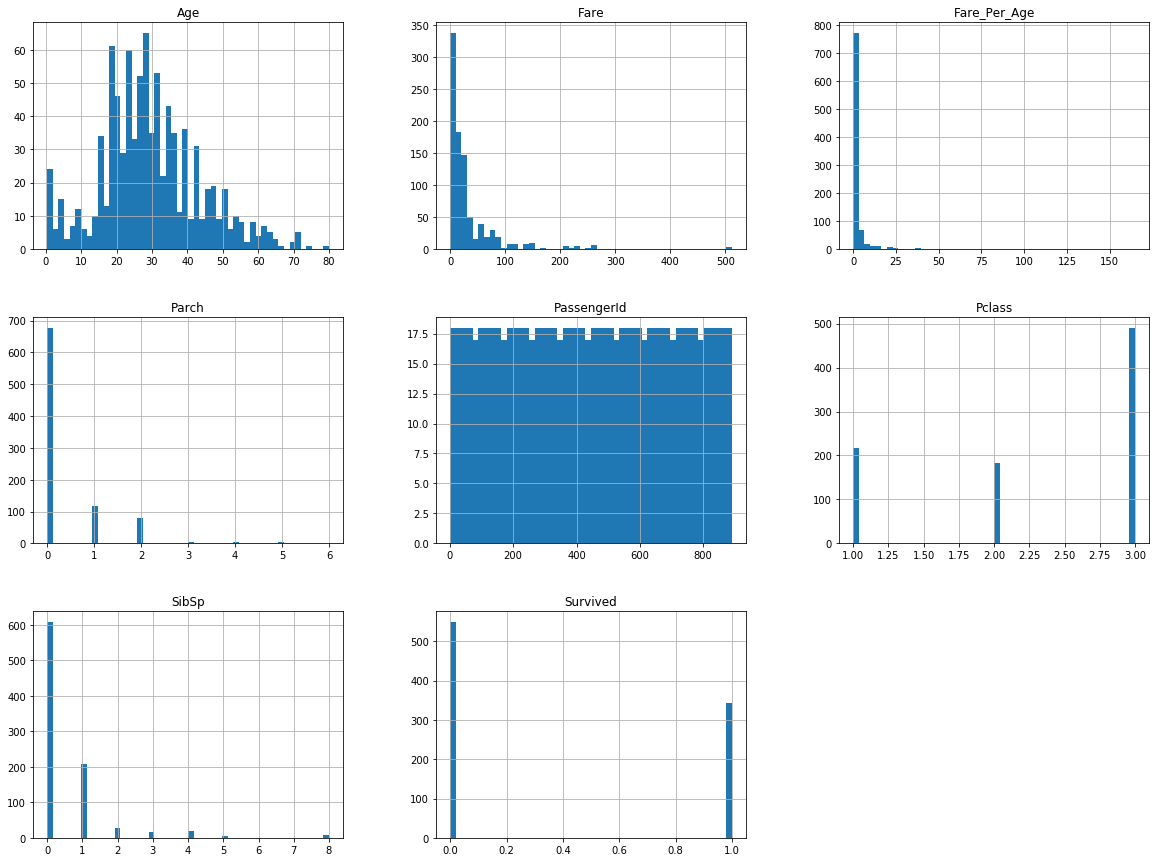

In [237]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

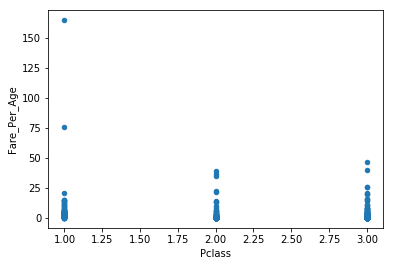

In [238]:
data.plot(kind="scatter", x="Pclass", y="Fare_Per_Age")

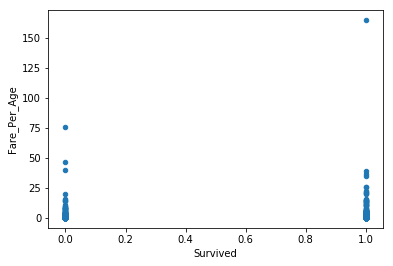

In [239]:
data.plot(kind="scatter", x="Survived", y="Fare_Per_Age")

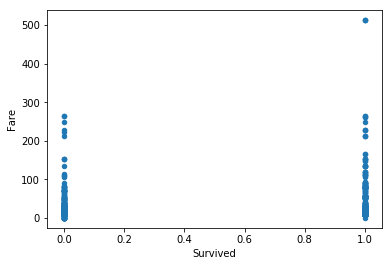

In [240]:
data.plot(kind="scatter", x="Survived", y="Fare")

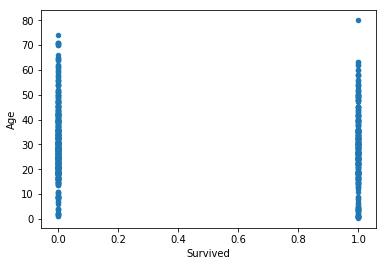

In [241]:
data.plot(kind="scatter", x="Survived", y="Age")

In [242]:
data["Cabin"].fillna("Z", inplace=True)

In [243]:
data["Chamber"] = [x[0] for x in data["Cabin"]]

In [244]:
data.drop("Cabin", axis=1, inplace=True)

In [245]:
data.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age,Fare_Per_Age,Chamber
0,1,0,3,male,1,0,7.2500,S,22.0,0.329545,Z
1,2,1,1,female,1,0,71.2833,C,38.0,1.875876,C
2,3,1,3,female,0,0,7.9250,S,26.0,0.304808,Z
3,4,1,1,female,1,0,53.1000,S,35.0,1.517143,C
4,5,0,3,male,0,0,8.0500,S,35.0,0.230000,Z


In [202]:
label = data["Survived"].copy()
data.drop("Survived", axis=1, inplace=True)

In [203]:
ids = data["PassengerId"].copy()
data.drop("PassengerId", axis=1, inplace=True)

In [204]:
sex_encoder = LabelBinarizer()
gender_1hot = sex_encoder.fit_transform(data["Sex"])
data["Gender"] = gender_1hot
data.drop("Sex", axis=1, inplace=True)

In [205]:
data.head()

,Pclass,SibSp,Parch,Fare,Embarked,Age,Fare_Per_Age,Chamber,Gender
0,3,1,0,7.2500,S,22.0,0.329545,Z,1
1,1,1,0,71.2833,C,38.0,1.875876,C,0
2,3,0,0,7.9250,S,26.0,0.304808,Z,0
3,1,1,0,53.1000,S,35.0,1.517143,C,0
4,3,0,0,8.0500,S,35.0,0.230000,Z,1


In [206]:
chamber_data = data["Chamber"]
data.drop("Chamber", axis=1, inplace=True)

chamber_encoder = LabelBinarizer()
chamber_encoder.fit(chamber_data)
chamber_1hot = chamber_encoder.transform(chamber_data)
chamber_1hot

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [207]:
embarked_data = data["Embarked"]
data.drop("Embarked", axis=1, inplace=True)

embarked_encoder = LabelBinarizer()
embarked_encoder.fit(embarked_data)
embarked_1hot = embarked_encoder.transform(embarked_data)
embarked_1hot

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [213]:
data.head()

,Pclass,SibSp,Parch,Fare,Age,Fare_Per_Age,Gender
0,3,1,0,7.2500,22.0,0.329545,1
1,1,1,0,71.2833,38.0,1.875876,0
2,3,0,0,7.9250,26.0,0.304808,0
3,1,1,0,53.1000,35.0,1.517143,0
4,3,0,0,8.0500,35.0,0.230000,1


In [226]:
train_X = data[list(data)].values
scalar = StandardScaler()
scalar.fit(train_X)
train_X = scalar.transform(train_X)
train_Y = label.values

In [225]:
test_data.head()

891